### Types

- [ ] Stores
- [ ] Loads

- [ ] Branches (LLVM Br vs br/indirect)

- [ ] CMP (LLVM CMP/Select vs CMP)
- [ ] FCMP

- [ ] CALL

- [ ] Add-Sub
- [ ] Mul
- [ ] Div (LLVM UDIV/SDIV/UREM/SREM vs DIV) ~> DIV already gives the remainder
- [ ] OR
- [ ] AND
- [ ] XOR

- [ ] SHL
- [ ] ASHR
- [ ] LSHR

- [ ] FADD
- [ ] FSUB
- [ ] FMUL
- [ ] FDIV



In [1]:
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(tidyr)
library(readr)
options(repr.plot.width=5, repr.plot.height=4)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## LLVM

In [2]:
get_llvm <- function(prefix){
    llvm = read.csv(paste(prefix, 'count_SSA.csv', sep='/'))
    llvm
}

# PIN

In [3]:
get_pin <- function(prefix){
    ps = read.csv(paste(prefix, 'stores.csv', sep='/'))
    pl = read.csv(paste(prefix, 'loads.csv', sep='/'))
    pbr = read.csv(paste(prefix, 'br.csv', sep='/')) 
    pbin = read.csv(paste(prefix, 'binops.csv', sep='/'))
    pin = Reduce(function(x, y) merge(x, y, all=TRUE, on=Benchmark), list(ps, pl, pbr, pbin))[0:252,]

    opcodes = list('store', 'load', 'br', 'indirect', 
                   'ADD', 'SUB', 'MUL', 'DIV', 
                   'XOR', 'AND', 'OR',
                   'SHL', 'ASHR', 'LSHR',
                   'FADD', 'FSUB', 'FMUL', 'FDIV',
                   'CMP', 'FCMP',
                   'CALL')

    for (op in opcodes){
        pin[tolower(op)] = pin[paste(op, '_before', sep='')] + pin[paste(op, '_main', sep='')] + pin[paste(op, '_end', sep='')]
    }

    pin %>% select(c('Benchmark',
                     'store', 'load', 'br', 'indirect', 
                     'add', 'sub', 'mul', 'div', 
                     'fadd', 'fsub', 'fmul', 'fdiv', 
                     'xor', 'and', 'or', 
                     'shl', 'ashr', 'lshr', 
                     'cmp', 'fcmp'))
}

In [4]:
pinO0 = get_pin('dataO0')
pinO1 = get_pin('dataO1')
pinO2 = get_pin('dataO2')
pinO3 = get_pin('dataO3')

llvmO0 = get_llvm('dataO0')
llvmO1 = get_llvm('dataO1')
llvmO2 = get_llvm('dataO2')
llvmO3 = get_llvm('dataO3')

In [5]:
get <- function(llvm_col, pin_col){
#     T = data.frame(llvmO0$Benchmark)
    
    llvm=list(llvmO0, llvmO1, llvmO2, llvmO3)
    pin=list(pinO0, pinO1, pinO2, pinO3)
    suffix=list('O0', 'O1', 'O2', 'O3')
    
    for (i in seq(1,4)){
        L = llvm[[i]]
        P = pin[[i]]
        S = suffix[[i]]
        
        df = merge(L[, append(c('Benchmark'), llvm_col)], P[, append(c('Benchmark'), pin_col)], on='Benchmark')
        df['visible'] = rowSums(df[, llvm_col, drop=FALSE]) / rowSums(df[, pin_col, drop=FALSE])
        df['invisible'] = 1 - df['visible']
        
        df = df %>% rename_at(vars(-ends_with('Benchmark')), function(x) paste(x, S, sep='_'))
        
        if (i == 1){
            T = df
        }
        else{
            T = merge(T, df, on=Benchmark)   
        }
    }
    
    is.na(T) = sapply(T, is.infinite)
    T = T %>% mutate(group = sapply(strsplit(as.character(Benchmark), "/"), function(x) x[2]))
    T %>% filter(!grepl("Misc|TSVC|mafft",Benchmark))
}


In [121]:
store = get('STORE', 'store')
load = get('LOAD', 'load')

br = get('BR', c('br', 'indirect'))

addsub = get(c('ADD', 'SUB'), c('add', 'sub'))
mul = get('MUL', 'mul')
div = get(c('UDIV', 'SDIV', 'UREM', 'SREM', 'SHL', 'ASHR', 'LSHR'), c('div', 'ashr', 'lshr', 'shl'))

xor = get('XOR', 'xor')
and = get('AND', 'and')
or = get('OR', 'or')

# shl = get('SHL', 'shl')
# ashr = get('ASHR', 'ashr')
# lshr = get('LSHR', 'lshr')

fadd = get('FADD', 'fadd')
fsub = get('FSUB', 'fsub')
fmul = get('FMUL', 'fmul')
fdiv = get('FDIV', 'fdiv')

cmp = get('CMP', 'cmp')
fcmp = get('FCMP', 'fcmp')


In [7]:
insts = list('store' = store, 'load' =load, 
          'br' = br, 
          'addsub' = addsub, 'mul' = mul, 'div' = div,
          'xor' = xor, 'and' = and, 'or' = or,
#           'shl' = shl, 'ashr' = ashr, 'lshr' = lshr,
          'fadd' = fadd, 'fsub' = fsub, 'fmul' = fmul, 'fdiv' = fdiv,
          'cmp' = cmp, 'fcmp' = fcmp)

## Mean

In [122]:
filtra <- function(df){
    df %>% filter(visible_O0 >= lower_fence(visible_O0) & visible_O0 <= upper_fence(visible_O0) &
                visible_O1 >= lower_fence(visible_O1) & visible_O1 <= upper_fence(visible_O1) &
                visible_O2 >= lower_fence(visible_O2) & visible_O2 <= upper_fence(visible_O2) &
                visible_O3 >= lower_fence(visible_O3) & visible_O3 <= upper_fence(visible_O3))
}

In [124]:
for (i in seq_along(insts)){
    df = insts[[i]]
    name = names(insts)[i]
    df2 = filtra(df)
    media = df2 %>% select(starts_with("visible")) %>% summarise_all(funs(mean), na.rm = T)
    desvio = df2 %>% select(starts_with("visible")) %>% summarise_all(funs(sd), na.rm = T)
#     print(name)
#     print(media)
#     print(desvio)
}


[1] "store"
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.4567124  0.4360234  0.4191537   0.420094
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.3523776  0.3503333   0.348929  0.3494285
[1] "load"
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.6433145  0.5551799   0.527675  0.5281402
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.3822661  0.3614963  0.3509063  0.3512959
[1] "br"
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.6239617  0.5104166  0.4926802   0.491634
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.3263359  0.3409817  0.3331209  0.3353073
[1] "addsub"
  visible_O0 visible_O1 visible_O2 visible_O3
1   0.626986  0.5245486  0.5106404  0.5081329
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.4602292  0.4210289  0.4139723  0.4170671
[1] "mul"
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.3097571  0.2292283  0.2322668  0.2317541
  visible_O0 visible_O1 visible_O2 visible_O3
1  0.4718759  0.3588498  0.3595215  0.3595506
[1] "div"
  visible_O0 vi

In [131]:
fadd %>% select(starts_with("visible")) %>% summarize_all(funs(sd), na.rm = T)
fsub %>% filter(Benchmark != 'Benchs/Linpack' & Benchmark != 'Benchs/BenchmarkGame/recursive' & Benchmark != 'Benchs/VersaBench/beamformer') %>% select(starts_with("visible")) %>% summarise_all(funs(sd), na.rm = T)
fmul %>% filter(group != 'mafft') %>% select(starts_with("visible")) %>% summarise_all(funs(sd), na.rm = T)
fdiv %>% filter(Benchmark != 'Benchs/PolyBench/medley/deriche') %>% select(starts_with("visible")) %>% summarise_all(funs(sd), na.rm = T)

visible_O0,visible_O1,visible_O2,visible_O3
0.3567586,0.3260943,0.3243159,0.3239745


visible_O0,visible_O1,visible_O2,visible_O3
0.564828,0.6657517,0.6181092,0.6168801


visible_O0,visible_O1,visible_O2,visible_O3
0.3116655,0.419066,0.2695903,0.2720342


visible_O0,visible_O1,visible_O2,visible_O3
0.1040898,0.1664077,0.1668541,0.1905882


## end mean

# Test suites

In [11]:
store$group %>% unique

[1] "ASC_Sequoia"     "ASCI_Purple"     "BenchmarkGame"   "BitBench"       
 [5] "CoyoteBench"     "cpu2006"         "Dhrystone"       "DOE_ProxyApps_C"
 [9] "Fhourstones"     "Fhourstones_31"  "FreeBench"       "Linpack"        
[13] "llubenchmark"    "MallocBench"     "McCat"           "McGill"         
[17] "mediabench"      "MiBench"         "nbench"          "NPB-serial"     
[21] "Olden"           "PAQ8p"           "PolyBench"       "Prolangs-C"     
[25] "Ptrdist"         "SciMark2-C"      "Shootout"        "sim"            
[29] "Stanford"        "tramp3d-v4"      "Trimaran"        "VersaBench"

In [12]:
std <- function(x){
    x = x[sapply(x, function(e) !is.na(e))]
    n = length(x)
    sqrt(sum((x - mean(x))^2)/(n))
}

upper <- function(x){
    x = x[sapply(x, function(e) !is.na(e))]
    mean(x) + 2*std(x)
}

lower <- function(x){
    x = x[sapply(x, function(e) !is.na(e))]
    mean(x) - 2*std(x)
}
                 
lower_fence <- function(x){
    Q1 = quantile(x, .25, na.rm = T)
    Q3 = quantile(x, .75, na.rm = T)
    IRQ = Q3 - Q1
    Q1 - 1.5*IRQ
}
                 
upper_fence <- function(x){
    Q1 = quantile(x, .25, na.rm = T)
    Q3 = quantile(x, .75, na.rm = T)
    IRQ = Q3 - Q1
    Q3 + 1.5*IRQ
}

In [174]:
plot <- function(df, name, filtra = T){
    mypal <- colorRampPalette( brewer.pal( 12 , "Paired" ) )
#     Q1 = quantile(df$visible, .25, na.rm = TRUE)
#     Q3 = quantile(df$visible, .75, na.rm = TRUE)
#     IRQ = Q3 - Q1
#     df2 = df %>% filter (invisible <= Q3 + 1.5*IRQ)

#     df2 = df %>%
#         filter(visible_O0 >= lower(visible_O0) & visible_O0 <= upper(visible_O0)) %>%
#         filter(visible_O1 >= lower(visible_O1) & visible_O1 <= upper(visible_O1)) %>%
#         filter(visible_O2 >= lower(visible_O2) & visible_O2 <= upper(visible_O2)) %>%
#         filter(visible_O3 >= lower(visible_O3) & visible_O3 <= upper(visible_O3)) %>%
    
    if (filtra == T){
        df2 = df %>%
            filter(visible_O0 >= lower_fence(visible_O0) & visible_O0 <= upper_fence(visible_O0) &
                visible_O1 >= lower_fence(visible_O1) & visible_O1 <= upper_fence(visible_O1) &
                visible_O2 >= lower_fence(visible_O2) & visible_O2 <= upper_fence(visible_O2) &
                visible_O3 >= lower_fence(visible_O3) & visible_O3 <= upper_fence(visible_O3)) %>%
            gather('id', 'visible', c('visible_O0', 'visible_O1', 'visible_O2', 'visible_O3'))
    }
    else {
        df2 = df %>% gather('id', 'visible', c('visible_O0', 'visible_O1', 'visible_O2', 'visible_O3'))
    }
    
    
    (ggplot(df2)
     + stat_ecdf(aes(visible, colour=id), geom = "step", pad = FALSE)
     + expand_limits(x=0)
     + ylim(0, 1)
     + xlab('Percentage Visible')
     + ylab('CDF(x)')
     + theme_light()
     + guides(colour = guide_legend(title=''))
     + scale_color_manual(name='', labels = c("O0", "O1", "O2", "O3"), values = c('grey90', 'grey65', 'grey45', 'grey30'))
     + theme(legend.position = 'top', panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
             legend.text = element_text(size=10))
     + theme(axis.title=element_text(size=10), axis.text=element_text(size=10))
     + guides(colour = guide_legend(override.aes = list(size=0.75))) 
     + ggsave(paste("pdfs/", name, ".pdf", sep=""), width=4, height=3, device="pdf")
    )
}

In [180]:
mul %>% filter(visible_O0 == 0.0) %>% nrow

[1] 51

In [175]:
for (i in seq_along(insts)){
    df = insts[[i]]
    name = names(insts)[i]
    plot(df, name)
}

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?


Warning message:
“Removed 377 rows containing non-finite values (stat_ecdf).”Warning message:
“Removed 377 rows containing non-finite values (stat_ecdf).”

Warning message:
“Removed 478 rows containing non-finite values (stat_ecdf).”Warning message:
“Removed 478 rows containing non-finite values (stat_ecdf).”

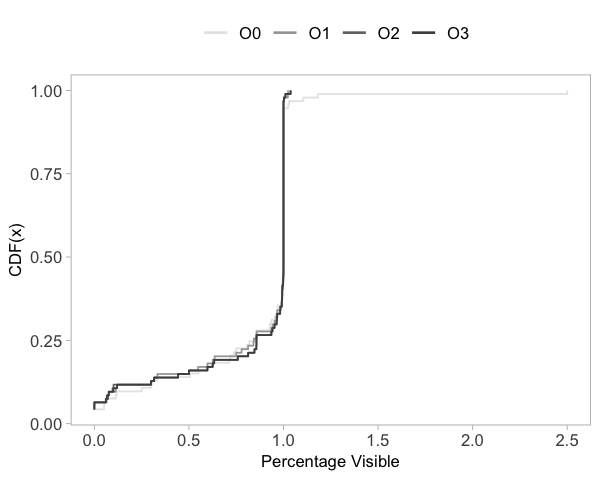

Warning message:
“Removed 387 rows containing non-finite values (stat_ecdf).”Warning message:
“Removed 387 rows containing non-finite values (stat_ecdf).”

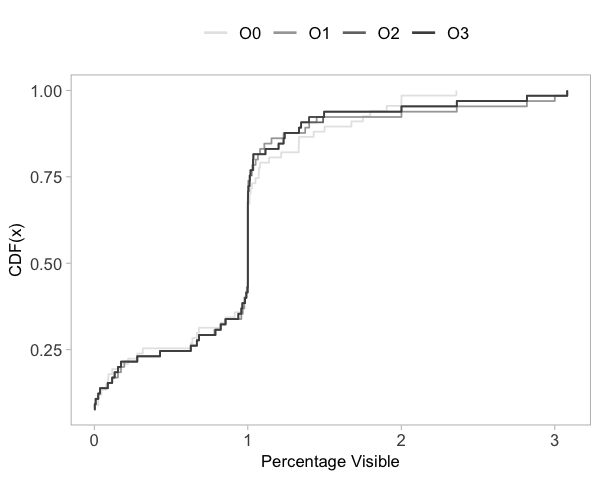

Warning message:
“Removed 399 rows containing non-finite values (stat_ecdf).”Warning message:
“Removed 399 rows containing non-finite values (stat_ecdf).”

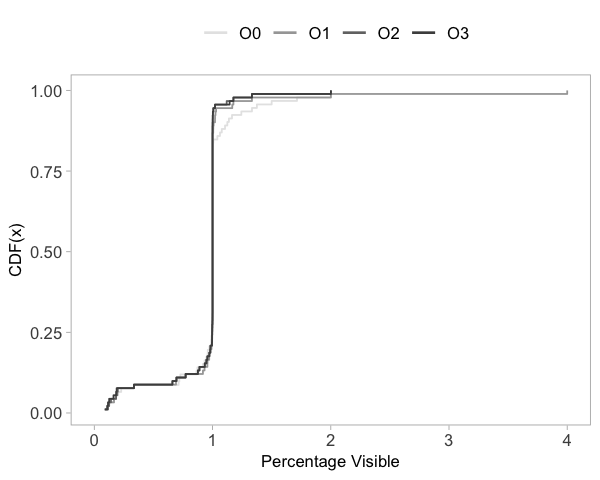

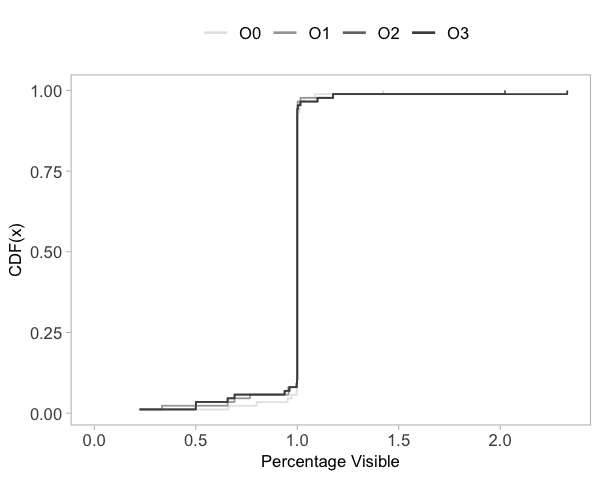

In [15]:
plot(fadd, 'fadd', filtra = F)
fsub %>% filter(Benchmark != 'Benchs/Linpack' & Benchmark != 'Benchs/BenchmarkGame/recursive' & Benchmark != 'Benchs/VersaBench/beamformer') %>% plot(., 'fsub', filtra = F)
fmul %>% filter(group != 'mafft') %>% plot(., 'fmul', filtra = F)
fdiv %>% filter(Benchmark != 'Benchs/PolyBench/medley/deriche') %>% plot(., 'fdiv', filtra = F)

In [16]:
store %>% select(Benchmark, group, starts_with("visible")) %>% filter(visible_O0 > visible_O3) %>% mutate(ratio = visible_O0 / visible_O3) %>% filter(group == "Stanford")

Benchmark,group,visible_O0,visible_O1,visible_O2,visible_O3,ratio
Benchs/Stanford/Bubblesort,Stanford,0.9904693,0.9904401,0.9904401,0.9904401,1.000029
Benchs/Stanford/Puzzle,Stanford,0.4193842,0.3661467,0.3611667,0.3599787,1.165025


# Correlation

In [142]:
time_reg = read_csv('time/time_ssa.csv') %>% select(Benchmark, Runtime) %>% rename(Runtime_reg = Runtime) %>% arrange(Benchmark)
time_mem = read_csv('time/time_no_ssa.csv') %>% select(Benchmark, Runtime) %>% rename(Runtime_mem = Runtime) %>% arrange(Benchmark)

# store_df = store %>% select(Benchmark, visible_O0) %>% arrange(Benchmark)
store_ir_reg = read_csv('dataO0/count_ssa.csv') %>% select(Benchmark, STORE) %>% rename(store_ir_reg = STORE) %>% arrange(Benchmark)
store_ir_mem = read_csv('count_no_ssa.csv') %>% select(Benchmark, STORE) %>% rename (store_ir_mem = STORE) %>% arrange(Benchmark)
store_x86_reg = read_csv('dataO0/stores.csv') %>% select(Benchmark, store_main) %>% rename(store_x86_reg = store_main) %>% arrange(Benchmark)
store_x86_mem = read_csv('stores_no_ssa.csv') %>% select(Benchmark, store_main) %>% rename(store_x86_mem = store_main) %>% arrange(Benchmark)

# load_df = load %>% select(Benchmark, visible_O0) %>% arrange(Benchmark)
load_ir_reg = read_csv('dataO0/count_ssa.csv') %>% select(Benchmark, LOAD) %>% rename(load_ir_reg = LOAD) %>% arrange(Benchmark)
load_ir_mem = read_csv('count_no_ssa.csv') %>% select(Benchmark, LOAD) %>% rename (load_ir_mem = LOAD) %>% arrange(Benchmark)
load_x86_reg = read_csv('dataO0/loads.csv') %>% select(Benchmark, load_main) %>% rename(load_x86_reg = load_main) %>% arrange(Benchmark)
load_x86_mem = read_csv('loads_no_ssa.csv') %>% select(Benchmark, load_main) %>% rename(load_x86_mem = load_main) %>% arrange(Benchmark)

# 
br_ir_reg = read_csv('dataO0/count_ssa.csv') %>% select(Benchmark, BR) %>% rename(br_ir_reg = BR) %>% arrange(Benchmark)
br_ir_mem = read_csv('count_no_ssa.csv') %>% select(Benchmark, BR) %>% rename (br_ir_mem = BR) %>% arrange(Benchmark)
br_x86_reg = read_csv('dataO0/br.csv') %>% select(Benchmark, br_main, indirect_main) %>% mutate(br_x86_reg = br_main + indirect_main) %>% arrange(Benchmark)
br_x86_mem = read_csv('br_no_ssa.csv') %>% select(Benchmark, br_main, indirect_main) %>% mutate(br_x86_mem = br_main + indirect_main) %>% arrange(Benchmark)

Parsed with column specification:
cols(
  Benchmark = col_character(),
  group = col_character(),
  Runtime = col_double()
)
Parsed with column specification:
cols(
  Benchmark = col_character(),
  group = col_character(),
  Runtime = col_double()
)
Parsed with column specification:
cols(
  .default = col_double(),
  Benchmark = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  Benchmark = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  Benchmark = col_character(),
  store_before = col_double(),
  store_main = col_double(),
  store_end = col_double()
)
Parsed with column specification:
cols(
  Benchmark = col_character(),
  store_before = col_double(),
  store_main = col_double(),
  store_end = col_double()
)
Parsed with column specification:
cols(
  .default = col_double(),
  Benchmark = col_character()
)
See spec(...) for full column specificati

In [188]:
time = inner_join(time_reg, time_mem, by='Benchmark')
store_df = inner_join(store_ir_mem, store_ir_reg, by='Benchmark') %>% inner_join(store_x86_reg, by='Benchmark') %>% inner_join(store_x86_mem, by='Benchmark')
load_df = inner_join(load_ir_mem, load_ir_reg, by='Benchmark') %>% inner_join(load_x86_reg, by='Benchmark') %>% inner_join(load_x86_mem, by='Benchmark')
br_df = inner_join(br_ir_mem, br_ir_reg, by='Benchmark') %>% inner_join(br_x86_reg, by='Benchmark') %>% inner_join(br_x86_mem, by='Benchmark') %>% 
    select(Benchmark, br_ir_mem, br_ir_reg, br_x86_mem, br_x86_reg)

df= inner_join(store_df, load_df, by='Benchmark', suffix = c('_store', '_load')) %>% 
    inner_join(., time, by='Benchmark') %>%
    inner_join(., br_df, by='Benchmark') %>%
    as_tibble() %>%
    mutate(
        Runtime_ratio = Runtime_mem / Runtime_reg,
        store_ratio = (store_ir_mem / store_x86_mem) / (store_ir_reg / store_x86_reg),
        load_ratio = (load_ir_mem / load_x86_mem) / (load_ir_reg / load_x86_reg),
        br_ratio = (br_ir_mem / br_x86_mem) / (br_ir_reg / br_x86_reg),
        group = sapply(strsplit(as.character(Benchmark), "/"), function(x) x[2])
    )

In [152]:
df2 = df %>% 
    filter(Runtime_mem >= 15 & group != 'CoyoteBench')
cor.test(df2$Runtime_ratio, df2$br_ratio, method='pearson')


	Pearson's product-moment correlation

data:  df2$Runtime_ratio and df2$br_ratio
t = -1.0645, df = 22, p-value = 0.2987
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5735141  0.1999253
sample estimates:
       cor 
-0.2213208 


In [95]:
library(latex2exp)
library(ggplot2)

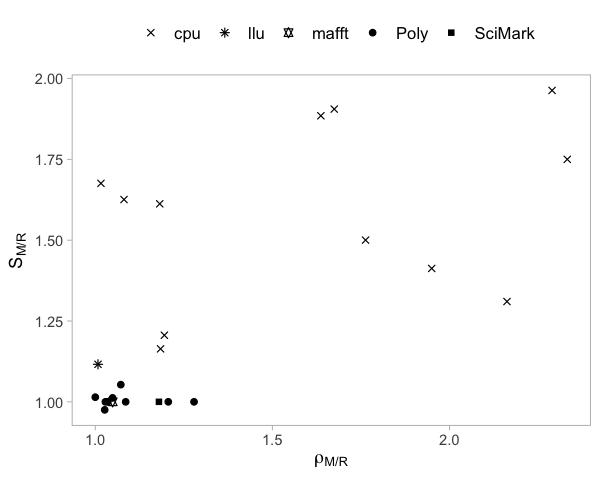

In [119]:
df2 %>% ggplot(.) + 
 ylab(TeX("$S_{M/R}$")) +
 xlab(TeX("$\\rho_{M/R}$")) +
 scale_shape_manual(name='', values=c(4, 8, 11, 19, 15), labels=c('cpu', 'llu', 'mafft', 'Poly', 'SciMark')) +
 geom_point(aes(x=store_ratio, y=Runtime_ratio, shape=group)) + 
 theme_light() +
 theme(legend.position = 'top', panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.text = element_text(size=10)) +
 guides(colour = guide_legend(override.aes = list(size=0.75))) +
 ggsave(paste("fig_store", ".pdf", sep=""), width=4, height=3, device="pdf")

# Address Sanitizer

In [154]:
time_asan = read_csv('time/time_asan.csv') %>% select(Benchmark, Runtime) %>% rename(Runtime_asan = Runtime) %>% arrange(Benchmark)
time_reg = read_csv('time/time_ssa.csv') %>% select(Benchmark, Runtime) %>% rename(Runtime_reg = Runtime) %>% arrange(Benchmark)

Parsed with column specification:
cols(
  Benchmark = col_character(),
  group = col_character(),
  Runtime = col_double()
)
Parsed with column specification:
cols(
  Benchmark = col_character(),
  group = col_character(),
  Runtime = col_double()
)


In [161]:
time = inner_join(time_asan, time_reg, by='Benchmark')
store_df = inner_join(store_ir_mem, store_ir_reg, by='Benchmark') %>% inner_join(store_x86_reg, by='Benchmark') %>% inner_join(store_x86_mem, by='Benchmark')
load_df = inner_join(load_ir_mem, load_ir_reg, by='Benchmark') %>% inner_join(load_x86_reg, by='Benchmark') %>% inner_join(load_x86_mem, by='Benchmark')

df= inner_join(store_df, load_df, by='Benchmark', suffix = c('_store', '_load')) %>% 
    inner_join(., time, by='Benchmark') %>%
    inner_join(., br_df, by='Benchmark') %>%
    as_tibble() %>%
    mutate(
        Runtime_ratio = Runtime_asan / Runtime_reg,
        store_ratio = (store_ir_mem / store_x86_mem) / (store_ir_reg / store_x86_reg),
        load_ratio = (load_ir_mem / load_x86_mem) / (load_ir_reg / load_x86_reg),
        br_ratio = (br_ir_mem / br_x86_mem) / (br_ir_reg / br_x86_reg),
        group = sapply(strsplit(as.character(Benchmark), "/"), function(x) x[2])
    )

In [164]:
df2 = df %>% 
    filter(Runtime_reg >= 15 & group != 'CoyoteBench')
cor.test(df2$load_ratio, df2$Runtime_ratio, method='pearson')


	Pearson's product-moment correlation

data:  df2$load_ratio and df2$Runtime_ratio
t = -8.6437, df = 23, p-value = 1.109e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9435486 -0.7323205
sample estimates:
       cor 
-0.8744255 


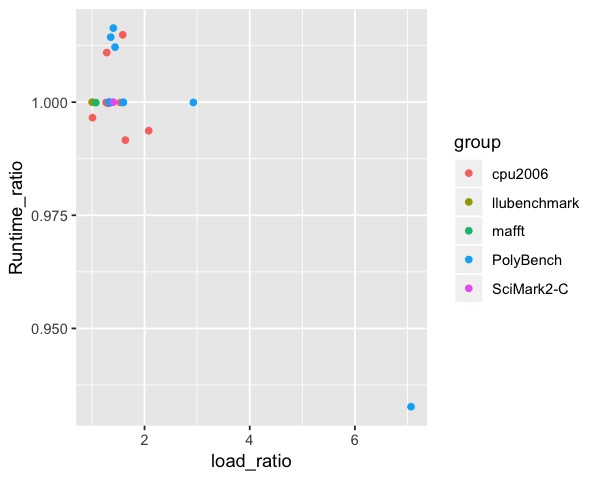

In [166]:
df2 %>% ggplot(.) +  geom_point(aes(x=load_ratio, y=Runtime_ratio, color=group))

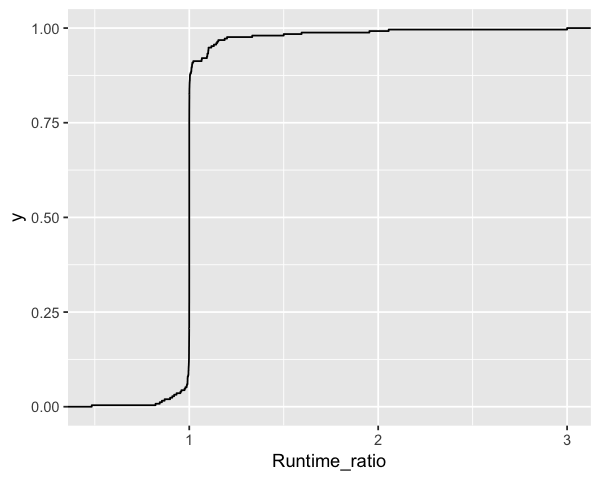

In [29]:
df %>% ggplot(.) + stat_ecdf(aes(Runtime_ratio))